# Kleiner Überblick

Hab mir das so gedacht, dass wir diesen Code für den Post verwenden, ist auf das Minimum reduziert. Alles was benötigt wird laden wir einfach aus dem Verzeichnis (Github?) rein damit wir ohne großen Code schnell zeigen können was wir wollen. 

Zweites Codefile preparation_code enthält dann den vollständigen Code mit den ganzen Berechnung etc., so wie er in unserem Standardmodell abgespeichert damit man die Berechnungen alle nachzeichnen kann.

https://forums.fast.ai/t/fastai-v0-7-install-issues-thread/24652
    
Link für Fastai, nach Erstellung des Environments aktiviert man zunächst das Environment, dann navigiert man seinen Präsiordner an

conda activate fastai-cpu 

cd "/Users/michaelschimpke/Documents/Präsentation/Colab Notebooks" 

jupyter notebook

# 1. Einleitung

Einführung Paper, Fastai, Pytorch, Transfer Learning, Tokenization, (Embedding? oder erst später?) etc.

### Frage: 

Wie sollen wir die Import Packages handhaben? Sie meinte ja der Code im Blogpost muss durchlaufen können, aber brauchen wir wirklich die ganzen Packages? Oder geben wir das in Github nochmal extra ab mit den Packages?

In [1]:
import pandas as pd
import numpy as np
import torch
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

import fastai
from fastai.imports import *
from fastai.torch_imports import *
from fastai.core import *
from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *
from fastai.text import *

import dill as pickle

#!pip install spacy
#!python -m spacy download en
import spacy
import html

import pickle
import collections

### Laden der fertigen Datensätze

Für Präsentationscode laden wir nur die fertigen Data Frames etc. ins Modell, spart sehr viel Code ein. Die gesamte Berechnung gebenw wir im anderen Preparation_Code File ab.

<b> Wichtig hier:</b> Für das Language Model laden wir die Datensätze aus dem LM Path, bei dem die Labels auf 0 gesetzt werden. Später im Classifier laden wir dann die Daten aus dem Clas Path mit den Labels.

Muss mal schauen dann was wir von dem Zeug wirklich brauchen und was nicht, im Endeffekt wollen wir ja nur einen Satz in Worten und in Tokens zeigen.

Die Zeile würd ich dann sogar rauslassen, ist zuviel Code.

Hab zusätzlich für Stoi auch mal ein Pickle Dump erstellt, damit wir das auch zur Not schnell reinladen können. Wobei die Zeile könnten wir auch lassen ist ja nicht so arg viel und sieht so aus als könnten wir gut programmieren.

In [3]:
#Load tokenized data
chunksize = 5000
dfTrn = pd.read_csv('lm/train.csv', header=None, chunksize=chunksize)
dfVal = pd.read_csv('lm/test.csv', header=None, chunksize=chunksize)

tokTrn = np.load('lm/tokTrn.npy')
tokVal = np.load('lm/tokVal.npy')

trnLm = np.load('lm/trnIds.npy')
valLm = np.load('lm/valIds.npy')

#Load presaved itos
with open('lm/itos.pkl', 'rb') as pickle_file:
    itos = pickle.load(pickle_file)

stoi = collections.defaultdict(lambda:0, 
                               {v:k for k,v in enumerate(itos)})

### Tokenization

Schnelle Erklärung Tokenization anhand eines kurzen Beispiels

Könnte dann so aussehen zb. Einmal in Worten...

In [34]:
tokTrn = np.load('lm/tokTrn.npy')
np.transpose(tokTrn[0])

array(['\n', 'xbos', '@jetblue', "'s", 'new', 't_up', 'ceo', 'seeks', 'the', 'right', 'balance', 'to',
       'please', 'passengers', 'and', 'wall', '...', '-', 'times', 'colonist'], dtype='<U10')

... und in Zahlen

In [33]:
trnLm = np.load('lm/trnIds.npy')
np.transpose(trnLm[0])

array([   2,    3,   26,   37,  162,    8,  642, 2150,    7,  210, 1735,    5,   89,  229,   18,  886,   57,
         42,  252,    0])

# 2.1 Language Model

Hier geht der Teil LM los. Würde anfangen mit den Embeddings, da wir das gleich im Matching brauchen werden. Am besteb wir verknüpfen das irgendwie indem wir auch gleich das Wikipedia Pretraining Model einführen, da ich aus diesem die Embedding Matrix gleich zeigen kann.

Vielleicht anfangen mit dem Wikimodell und dann hinführen auf die übernommenen trainierten Embeddings und LSTMs.

Kurze Erläuterung zu Embeddings, dazu würde ich auch schnell aus Wiki die Matrix

### Embedding

Bin mir noch nicht ganz schlüssig wo wir das Embedding unterbringen. Später im Numpy Part muss das eigentlich schon erklärt sein weil wir das ja im Modell auch schon trainieren um beim Matching brauchen.

Da beim Matching die Embeddings übernommen würd ich das hier erklären.

Zeige dann am besten die Embeddingmatrix hier, dazu kurze Erklärung wir haben 238462 Wörter im Vocabulary und jedes Wort wird durch 400 Embedding Features repräsentiert.

In [58]:
lm_wgts_wiki = torch.load('wt103/fwd_wt103.h5', map_location=lambda storage, 
                  loc: storage)
print(lm_wgts_wiki['0.encoder.weight'])


-1.2274e-01  2.7886e-01 -3.8850e-01  ...  -1.0404e-01  1.9580e-02  1.8548e-01
 1.4854e-05 -2.3424e-05  1.9693e-05  ...   2.1349e-05  2.1776e-05 -1.2394e-05
 1.8070e-01  1.5874e+00 -1.1738e-01  ...  -4.5935e-02 -8.1352e-02  1.8054e-01
                ...                   ⋱                   ...                
-1.8595e-03 -6.8529e-03  1.6999e-03  ...   1.7039e-03  4.1632e-03 -1.3171e-03
-2.3120e-03 -6.9001e-03  1.8772e-03  ...   5.0309e-04  4.6596e-03 -2.5850e-03
-2.2463e-03 -9.1512e-03  1.3927e-03  ...   1.2296e-03  5.8085e-03 -1.8940e-03
[torch.FloatTensor of size 238462x400]



### Matching

Das Ding ist noch viel zu lang, da müssen wir uns überlegen ob wir das irgendwie kürzen oder über mehrere Zeilen verteilen können. Denke wir können wahrscheinlich das itoswiki und stoiwiki weglassen.

In [6]:
em_sz, nh, nl = 400, 1150, 3

with open('wt103/itos_wt103.pkl', 'rb') as pickle_file:
    itosWiki = pickle.load(pickle_file)
    
stoiWiki = collections.defaultdict(lambda:-1, {v:k for k,v 
                                              in enumerate(itosWiki)})

encWgts = lm_wgts_wiki['0.encoder.weight'].numpy()
rowM = np.mean(encWgts, axis = 0)

newWm = np.zeros((len(itos), em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoiWiki[w]
    newWm[i] = encWgts[r] if r>=0 else rowM
    
lm_wgts_wiki['0.encoder.weight'] = np.transpose(newWm)
lm_wgts_wiki['0.encoder_with_dropout.embed.weight'] = np.transpose(np.copy(newWm))
lm_wgts_wiki['1.decoder.weight'] = np.transpose(np.copy(newWm))

## Language Model Structure

Hier können wir anfangen das Modell aufzuziehen, vielleicht erst die Parameter und dann den Learner für das Language Model. 

Hier würde ich das Bild vom Model Overview zum ersten Mal einfügen, passend zur allgemeinen Erklärung des Modells.

Würde dann hier auch mit <b>Sandras Erläuterungen zu BPTT, Batch Size, Adam etc.</b> starten. Hier können wir das schön auseinanderziehen und dann den Learner aufziehen. Dann noch LanguageModelLoader erklären

In [7]:
wd = 1e-7
bptt = 70
bs = 64
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
t = len(np.concatenate(trnLm))

trnDl = LanguageModelLoader(np.concatenate(trnLm), bs, bptt)
valDl = LanguageModelLoader(np.concatenate(valLm), bs, bptt)

### Erklärung AWD-LSTMs, Dropout, LanguageModelData Funktion

Hier dann <b>AWD-LSTMs mit Dropout</b> (falls wir darauf überhaupt so viel eingehen). get_model function erklären. Danach freezing erklären

In [24]:
md = LanguageModelData('', 1, len(itos), trnDl, valDl, bs=bs, 
                       bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti = drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute = drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

### Erster Fit mit Freezing, Erklärung STLR

Wir müssen meiner Meinung nach hier das Modell im Jupyter Notebook nochmal durchlaufen lassen, da wir die Modellparameter wie Loss und Accuracy sonst nicht bzw. kaum laden und zeigen können.

<b>Erklärung Freezing und Slanted Triangular Learning Rates hier.</b>

In [ ]:
#Durchführung erst ganz am Ende
learner.model.load_state_dict(lm_wgts_wiki)
lr=3e-3
lrs = lr
#learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) 
#learner.save('lm_last_ft')

### Losses, Accuracy 1. Epoche mit Freezing

Output aus dem Model (wird natürlich noch auf wenige Schlüsselmatrizen heruntergetrimmt, um das etwas anschaulicher zu machen

In [32]:
lm_wgts_fr = torch.load('models/lm_last_ft.h5', map_location=lambda storage, 
                  loc: storage)
print(lm_wgts_fr)

OrderedDict([('0.encoder.weight', 
-1.5972e-01  3.2485e-01 -4.4057e-01  ...  -1.4884e-01 -4.2950e-03  1.4028e-01
 3.7763e-02 -3.9745e-02  5.0021e-02  ...   3.9405e-02  4.0394e-02 -2.1133e-02
-3.8825e-01 -4.0622e-01 -1.7479e-01  ...   7.0953e-02  2.7808e-01  7.5862e-02
                ...                   ⋱                   ...                
-1.2570e-02 -1.4090e-01  1.2269e-02  ...   1.2281e-02  5.5557e-02 -4.0179e-03
-7.3162e-01 -1.1589e+00  3.6999e-01  ...   2.3351e-01 -6.6950e-02  4.2597e-02
-3.1653e-01 -9.5473e-01 -1.0659e-01  ...  -2.2530e-01  2.1217e-01  2.5796e-01
[torch.FloatTensor of size 4409x400]
), ('0.encoder_with_dropout.embed.weight', 
-1.5972e-01  3.2485e-01 -4.4057e-01  ...  -1.4884e-01 -4.2950e-03  1.4028e-01
 3.7763e-02 -3.9745e-02  5.0021e-02  ...   3.9405e-02  4.0394e-02 -2.1133e-02
-3.8825e-01 -4.0622e-01 -1.7479e-01  ...   7.0953e-02  2.7808e-01  7.5862e-02
                ...                   ⋱                   ...                
-1.2570e-02 -1.4090e-01  1

### Unfreeze, lr_find Algorithmus

Jetzt unfreeze, dann Erklärung lr_find Algorithmus

<b>Was wichtig ist:</b> Um den Plot hier durch den Code hineinzuladen, müssen wir das Ding durchlaufen lassen. Das Bild hier per Bilddatei reinzuladen würde glaub am Ziel vorbeischrammen, das man das Notebook selbst nachbilden kann.

In [ ]:
#learner.load('lm_last_ft')
#learner.unfreeze()
#learner.lr_find(start_lr=lrs/1000, end_lr=lrs*1000)
#learner.sched.plot()

### Zweiter Fit mit unfrozen Layers

Dann erneuter Fit, hier muss noch die Learning neu gesetzt werden und evtl. mit discriminative learning rate angesetzt werden, da wir hier ja auch die LSTM Layer trainieren.

Evtl. dann learner.save für die LM Prediction, kann aber auch raus

In [ ]:
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=4)
#learner.save('lm2')

### Unfrozen Matrizen zeigen

Erklärung zu den unfrozen Parametern. 

In [38]:
lm_wgts_unfr = torch.load('models/lm2.h5', map_location=lambda storage, 
                  loc: storage)
print(lm_wgts_unfr)

OrderedDict([('0.encoder.weight', 
-1.4777e-01  3.5498e-01 -4.9052e-01  ...  -1.5741e-01 -3.6893e-02  7.1525e-02
 9.0088e-02 -1.1824e-01  1.5968e-01  ...   1.5601e-01  1.3824e-01  1.0296e-02
-3.7896e-01 -3.7842e-01 -1.9198e-01  ...   4.1058e-02  2.4902e-01  9.4805e-02
                ...                   ⋱                   ...                
-2.0592e-02 -2.0642e-01  1.3304e-01  ...   9.0279e-02  9.7593e-02  2.9149e-02
-6.7843e-01 -1.1849e+00  3.6680e-01  ...   3.5038e-01 -3.7000e-02  3.6783e-02
-3.2418e-01 -1.0141e+00 -9.3502e-02  ...  -1.7836e-01  2.3915e-01  2.2841e-01
[torch.FloatTensor of size 4409x400]
), ('0.encoder_with_dropout.embed.weight', 
-1.4777e-01  3.5498e-01 -4.9052e-01  ...  -1.5741e-01 -3.6893e-02  7.1525e-02
 9.0088e-02 -1.1824e-01  1.5968e-01  ...   1.5601e-01  1.3824e-01  1.0296e-02
-3.7896e-01 -3.7842e-01 -1.9198e-01  ...   4.1058e-02  2.4902e-01  9.4805e-02
                ...                   ⋱                   ...                
-2.0592e-02 -2.0642e-01  1

### save_encoder

Jetzt Erklärung des save_encoder Befehls mit dem Abriss des Softmax Layers.

In [ ]:
#learner.save_encoder('lm2_enc')

# 2.2 Classifier Modell

Einleitung Classifer, Struktur (aufsetzen der Linear Blocks auf den Encoder), Bild mit Classifierumrandung

### Parameter

Parameter neu setzen, neue Parameter erklären, etc. Frage ist, ob wir das mit den min_lbl usw. einfach rausnehmen und einfach = 3 setzen, den vollen Code haben wir dann ja eh im preparation_code file.

In [41]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

### Datensätze mit Labels laden

Nun laden wir die Daten aus dem clas Path, damit wir die Labels dazuhaben.

Stoi und Itos brauchen wir nicht neu laden wie im Colab, haben das schon im Notebook drin.

Hier wieder die Frage, welche wir von den Daten wir wirklich brauchen. 

In [45]:
tok_trn = np.load('clas/tmp/tok_trn.npy')
tok_val = np.load('clas/tmp/tok_val.npy')

trn_clas = np.load('clas/tmp/trn_ids.npy')
val_clas = np.load('clas/tmp/val_ids.npy')
trn_labels = np.load('clas/tmp/trn_labels.npy')
val_labels = np.load('clas/tmp/val_labels.npy')

### Sortish Sampler

Jetzt kommt die große Frage, ob und inwiefern wir den Sortish Sampler hineinnehmen. Er ist halt leider wichtig damit der Code funktioniert. Vielleicht können wir es aber auch so machen das wir im Preparation Code trn_dl und val_dl abspeichern und hier einfach über pickle oder np.load hineinladen und kurz skizzieren das für Datensätze sind

In [46]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)

trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), 
                          bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1,
                    pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, 
                    pad_idx=1, sampler=val_samp)
md = ModelData('', trn_dl, val_dl)

### Drops und RNN Classifier

Erklärung 

Erklärung Drops Werte (scheint zu funktionieren, Howard hat selbst herumprobiert und die Kombination gefunden, gibt keinen Algorithmen um alle Drops gleichzeitig optimal zu bestimmen)

Erklärung get_rnn_classifer

<b> Erklärung Concat Pooling:</b> Würde hier mit dem Concat Pooling starten, mit dem Bild vielleicht dazu, da wir hier die $em\_sz*3$ schon drin haben.

Erläuterung Aufbau auf LSTMs (Concat Layer, Linear ReLU Layer 50, Classifier Softmax Layer 3)

In [47]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.7
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, 
                      n_layers=nl, pad_token=1,
                      layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
                      dropouti=dps[0], wdrop=dps[1],        
                      dropoute=dps[2], dropouth=dps[3])
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

### RNN Learner

Erklärung RNN_Learner, dazu reg_fn und clip Attribute. Kurz Accuracy abhandeln.

In [48]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

### Discriminative Learning Rates

Erläuterung DLRs

In [49]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

### Weight Decay und Encoder

WD könnten wir eigentlich auch zu den anderen Parametern packen. 

Jetzt Referenz zum Encoder, wir bauen die gespeicherten Embeddings und LSTMs vor unseren RNN Classifier um das Transfer Learning zu ermöglichen.

In [50]:
wd = 1e-7
learn.load_encoder('lm2_enc')

### Gradual unfreezing

Wieder unfreezing, dieses Mal Gradual Unfreezing mit mehreren Stufen, da wir nach dem LSTM nun zwei untrainierte Layer im Classifier (nicht wie im LM ein Softmax Layer) haben und diese nacheinander antrainieren. Denke hier müssen die Matrizen dann nicht mehr gezeigt werden. Ich kann ja zur Not die zwei Codezeilen dazu in Kommentare packen.

Dazu dann wieder Referenz zum LR_find, danach der Plot (Modell muss im JN durchlaufen). Für den Fit mit DLR $lrs$.

Den learn.save brauchen wir eigentlich nur, falls ich die Weightmatrizen zwecks Unfreezing nochmal zeigen soll

(Ignoriert den Plot, hab am Anfang aus Versehen ohne Hashtag vorm lr_find durchlaufen lassen

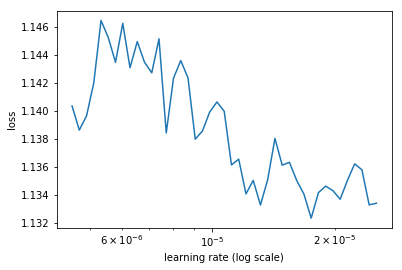

In [52]:
learn.freeze_to(-1)
#learn.lr_find(lrs/1000)
learn.sched.plot()
#learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))
learn.save('clas_0')

### Freezing Matrix 1

Optional Matrizen für Freezing 1

In [ ]:
#clas_wgts_fr1 = torch.load('models/clas_0.h5', map_location=lambda storage, 
#                 loc: storage)
#print(clas_wgts_fr1)

### Zweiter Fit

Gradual Unfreezing des ReLU 50 Layers

In [ ]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

### Freezing Matrix 2

Optional Matrizen für Freezing 2

In [53]:
#clas_wgts_fr2 = torch.load('models/clas_1.h5', map_location=lambda storage, 
#                 loc: storage)
#print(clas_wgts_fr2)

### Finaler Fit

Unfreeze aller Layer (muss wieder durchlaufen um Losses und Accuracy zu zeigen)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 1, wds=wd, cycle_len=5, use_clr=(32,10))

### Model Matrix final

Optional Matrizen für Unfreezing

In [ ]:
#clas_wgts_unfr = torch.load('models/clas_2.h5', map_location=lambda storage, 
#                 loc: storage)
#print(clas_wgts_unfr)

# 3. Wie läuft Input durchs Model durch das Model durch (Numpy Michi)

### Sentence Preparation

Vorbereitender Code, muss hier aber hinein damit man selbst den Satz festlegen kann für das Modell falls wir eine Prediction machen wollen (was schon ganz cool wäre), vielleicht kann man den Code hier verstecken.

Muss mir da noch eine elegantere Lösung überlegen wie ich das sauber hier hineinbekomme. Vermutlich werde ich das irgendwie mit Ausführung und Ablegung im Preparation_Code machen und das dann hier einfach hineinladen. Ich kann ja darauf verweisen dass man zum Ändern des Satzes im Preparation Code das neu laufen und abspeichern muss.

In [67]:
text = 'My flight was on'
labels = 0
text = pd.Series(text)
labels = pd.Series(labels)

text = pd.Series.as_matrix(text)
labels = pd.Series.as_matrix(labels)

colNames = ['labels','text']
textdf = pd.DataFrame({'text':text, 'labels':labels}, columns = colNames)
textdf.to_csv('Test_lm/text.csv', header=False, index=False)

/Users/michaelschimpke/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/michaelschimpke/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Nach dem aktuellen Stand brauch ich noch die get_all, versuche aber das rauszukriegen.

In [79]:
re1 = re.compile(r'  +')

# cleaning function
def cleaning(x):
   x = x.replace('#', '').replace('&amp;', '&')
   #return re1.sub(' ', html.unescape(x))
   return re1.sub(' ', re.sub('https?://[A-Za-z0-9./]+', '',html.unescape(x)))


# tokenizer function
def get_texts(df, n_lbls=1):
    labels = np.unique(df.iloc[:,range(n_lbls)].values, return_inverse=True)[n_lbls]
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): 
        texts += df[i].astype(str)
    texts = texts.apply(cleaning).values.astype(str)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

# iterator function
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [82]:
chunksize = 1
BOS = 'xbos'
textdf = pd.read_csv('Test_lm/text.csv', header=None, chunksize=chunksize)

tok_text = get_all(textdf,1)
tok = (tok_text[0])
print(tok)

0


OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

### Beispiel erste Wörter aus Vocab

In [83]:
list(stoi.items())[0:10]

[('_unk_', 0),
 ('_pad_', 1),
 ('\n', 2),
 ('xbos', 3),
 ('.', 4),
 ('to', 5),
 ('i', 6),
 ('the', 7),
 ('t_up', 8),
 ('!', 9)]

### Tokenized Sentence

In [84]:
#Numeral tokens for words
textLm = [[stoi[o] for o in p] for p in tok]
textLm = textLm[0]
print(textLm)

NameError: name 'tok' is not defined